In [0]:
import os
import torch
import pandas as pd
import torchvision 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
from matplotlib import pyplot as plt
%matplotlib inline 
import random
import PIL
from PIL import Image
import time

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pwd

'/content'

In [0]:
transform_train=torchvision.transforms.Compose([torchvision.transforms.Resize(40),
                                                torchvision.transforms.RandomHorizontalFlip(),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.4914,0.4822,0.4465],std=[0.2023,0.1994,0.2010])])

transform_test=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize([0.4914,0.4822,0.4465],[0.2023,0.1994,0.2010])])

In [144]:
train=torchvision.datasets.CIFAR10(root='drive/My Drive/CIFAR-10_Kaggle/data',train=True,download=True,transform=transform_train)

test=torchvision.datasets.CIFAR10(root='drive/My Drive/CIFAR-10_Kaggle/data',train=False,download=True,transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
indices=list(range(50000))
np.random.shuffle(indices)

In [0]:
train_loader=torch.utils.data.DataLoader(train,batch_size=200,num_workers=4,sampler=torch.utils.data.SubsetRandomSampler(indices[:45000]))
valid_loader=torch.utils.data.DataLoader(train,batch_size=200,num_workers=4,sampler=torch.utils.data.SubsetRandomSampler(indices[45000:]))
test_loader=torch.utils.data.DataLoader(test,batch_size=200,shuffle=False,num_workers=4)

In [0]:
data_train_iter=iter(train_loader)

In [0]:
data_valid_iter=iter(valid_loader)
data_test_iter=iter(test_loader)

In [0]:
#img=np.asarray(train2[0])
#img=np.transpose(img,[1,2,0])
#plt.imshow(img)

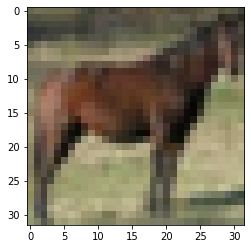

In [0]:
#plt.imshow(torchvision.transforms.ToPILImage()(train2[0]).convert("RGB"))

In [149]:
(len(data_train_iter),len(data_valid_iter),len(data_test_iter))

(225, 25, 50)

In [103]:
type(data_train_iter)

torch.utils.data.dataloader._MultiProcessingDataLoaderIter

In [0]:
img,label=next(data_train_iter)

In [0]:
class Residual(nn.Module):  #resnet block
  def __init__(self,input_channel,output_channel,use1x1conv=False,strides=1,**kwargs):
    super(Residual,self).__init__(**kwargs)
    self.conv1=nn.Conv2d(in_channels=input_channel,out_channels=output_channel,kernel_size=3,stride=strides,padding=1)
    self.bn1=nn.BatchNorm2d(output_channel)
    self.acti=nn.ReLU(inplace=True)
    self.conv2=nn.Conv2d(in_channels=output_channel,out_channels=output_channel,kernel_size=3,padding=1)
    self.bn2=nn.BatchNorm2d(output_channel)
    if use1x1conv:
      self.conv1x1=nn.Conv2d(in_channels=input_channel,out_channels=output_channel,kernel_size=1,stride=strides)
    else:
      self.conv1x1=None

  def forward(self,x):
    y=self.acti(self.bn1(self.conv1(x)))
    y=self.bn2(self.conv2(y))
    if self.conv1x1:
      x=self.conv1x1(x)
    return self.acti(y+x)


In [0]:
def resnet_block(input_channel,output_channel,num_residuals,first_block=False):
  blk=[]
  for i in range(num_residuals):
    if i==0 and not first_block: 
      blk.append(Residual(input_channel,output_channel,use1x1conv=True,strides=2))
    else:
      blk.append(Residual(output_channel,output_channel))
    return blk


In [0]:
resnet18=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3),
                       nn.BatchNorm2d(64),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [0]:
res1=nn.Sequential(*resnet_block(64,64,2,first_block=True))
res2=nn.Sequential(*resnet_block(64,128,2))
res3=nn.Sequential(*resnet_block(128,256,2))
res4=nn.Sequential(*resnet_block(256,512,2))

In [0]:
class Flatten(nn.Module):
  def forward(self,x):
    return x.reshape(x.size(0),-1)

In [0]:
resnet18=nn.Sequential(resnet18,res1,res2,res3,res4,nn.AdaptiveMaxPool2d((1,1)),Flatten(),nn.Linear(512,10))

In [138]:
def init_weights(m):
  if type(m)==nn.Linear or type(m)==nn.Conv2d:
    nn.init.xavier_uniform_(m.weight)

resnet18.apply(init_weights)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (acti): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (acti): ReLU(inplace=True)
      (conv2): Conv2d(128,

In [0]:
def train_net(net,val,loss_func,num_epochs,learning_rate,weight_decay,device):
  net.to(device)
  optimizer=optim.SGD(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
  for epoch in range(num_epochs):
    #train_loss,train_acc,n,start=torch.tensor([0.0],dtype=torch.float32,device=device),torch.tensor([0.0],dtype=torch.float32,device=device),0,time.time()

    train_loss,train_acc,n,start=0.0,0.0,0.0,time.time()
    for i,data in enumerate(train_loader,0):
      img,label=data
      net.train()
      optimizer.zero_grad()
      img,label=img.to(device),label.to(device)
      label_pred=net(img)
      loss=loss_func(label_pred,label)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        label=label.long()
        train_loss+=loss.float()
        train_acc+= torch.sum((torch.argmax(label_pred,dim=1)==label)).float()
        n +=label.shape[0]
    train_loss=train_loss/n
    train_acc=train_acc/n
    n=0.0
    if val:
      valid_acc=torch.tensor([0.0],dtype=torch.float32,device=device)
      for i,data in enumerate(valid_loader,0):
        img,label=data
        img,label=img.to(device),label.to(device)
        pred=net(img)
        valid_acc+= torch.sum((torch.argmax(pred,dim=1)==label)).float()
        n+=label.shape[0]
    valid_acc=valid_acc/n
    print("epoch: %d, trainloss: %f , train acc: %f , valid_acc: %f" % (epoch+1,train_loss,train_acc,valid_acc))

In [0]:
loss_func=nn.CrossEntropyLoss()
num_epochs=5
learning_rate=0.1
weight_decay=0.0001
device=torch.device('cuda:0')

In [162]:
train_net(resnet18,True,loss_func,num_epochs,learning_rate,weight_decay,device)

epoch: 1, trainloss: 0.006280 , train acc: 0.547444 , valid_acc: 0.585800


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524752a828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524b868710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

epoch: 2, trainloss: 0.005186 , train acc: 0.630556 , valid_acc: 0.644600


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524752a828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524b868710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

epoch: 3, trainloss: 0.004472 , train acc: 0.684556 , valid_acc: 0.693800


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524752a828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524b868710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

epoch: 4, trainloss: 0.003917 , train acc: 0.724200 , valid_acc: 0.695600


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524752a828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f524b868710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

epoch: 5, trainloss: 0.003410 , train acc: 0.758667 , valid_acc: 0.717600


In [0]:
torch.save(resnet18.state_dict(),"/content/drive/My Drive/CIFAR-10_Kaggle/first_checkpoint.pth")